> Tests for building preprocessing module.

---

# Setup

##### Set Root Dir as CWD

In [25]:
import os

# Navigate to project root (if not already there)
if os.path.split(os.getcwd())[1] != "cs374-project":
    %cd ../

##### Imports

In [26]:
import numpy as np
import pandas as pd

import spacy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Local
from src.preprocesser import ReviewPreprocessor

# Load

In [27]:
path = "data/yelp/reviews/"

In [28]:
%%time
# Load dev set (10% of total data) as train
train_all = pd.read_pickle(path + "train.xz")

CPU times: total: 32.7 s
Wall time: 32.8 s


In [29]:
%%time
# Load test set (10% of total data) as test
test_all = pd.read_pickle(path + "test.xz")

CPU times: total: 4.67 s
Wall time: 4.68 s


In [30]:
#num_samples = (10_000, 10_000)

train = train_all.iloc[:] #num_samples[0]]
test = test_all.iloc[:] #num_samples[1]]

In [31]:
train

,text,stars
2903612,I like Wedding Belles for an odd reason. I set...,5
5050964,We had a great stay here. I felt like we got a...,5
1226557,"A unique place for sure, not your standard bre...",3
776083,This will be a short review on service and gri...,4
227582,Great barbershop. Super friendly staff. They a...,5
...,...,...
3578067,I've not personally had the bad experiences th...,4
424533,Dive bar.\nNew ownership has improved the menu...,3
28275,"This place is so addicting, good vegan options...",5
2949771,"What is not to love about Wingfield Park, down...",5


##### Save Target

In [32]:
# Save reviews stars from 0-4
y_train = tf.convert_to_tensor(train["stars"].values - 1)
y_test = tf.convert_to_tensor(test["stars"].values - 1)

# Preprocess

In [62]:
%%time
batch_size = 2000
n_processes = 4

maxlen = 200         # Number of words per review to consider
vocab_size = 30_000  # Size of vocabulary

# Configure preprocessor
prep = ReviewPreprocessor(vocab_size, maxlen, alpha_only=False, split_digits=True)

# Preprocess text
X_train_norm = prep.normalize(train["text"], batch_size, n_processes)
X_test_norm = prep.normalize(test["text"], batch_size, n_processes)

# Fit tokenizer
prep.fit_tokenizer(X_train_norm)

# Convert to tensor of padded sequences
X_train = prep.to_tensor(X_train_norm)
X_test = prep.to_tensor(X_test_norm)

CPU times: total: 1h 3min 3s
Wall time: 1h 3min 53s


##### Save Results

In [63]:
%%time
pd.Series(X_train_norm).to_pickle(path + "train_prep.xz")
pd.Series(X_test_norm).to_pickle(path + "test_prep.xz")
prep.save_as_pickle("prototypes/preprocessors/prep_v4.pickle")

CPU times: total: 21min 12s
Wall time: 21min 35s


##### View Before and After Preprocessing

In [64]:
print_idx = 0
print(test["text"].iloc[print_idx])
print("\n - - - - \n")
print(X_test_norm[print_idx], len(X_test_norm[print_idx]))
print("\n - - - - \n")
print(X_test[print_idx])

I have never been more frightened in my life.  I screamed, fell on the floor, and ran for my life.  I was literally covered in sweat and needed my inhaler multiple times.  The campus is huge and VIP is definitely the move.  Pennhurst is an amazing campus with lots of history and the actors are fully committed to making the experience hair raising.  I would suggest this place to anyone looking for a frighting experience.

 - - - - 

['frightened', 'life', '.', 'screamed', ',', 'fell', 'floor', ',', 'ran', 'life', '.', 'literally', 'covered', 'sweat', 'needed', 'inhaler', 'multiple', 'times', '.', 'campus', 'huge', 'vip', 'definitely', '.', 'pennhurst', 'amazing', 'campus', 'lots', 'history', 'actors', 'fully', 'committed', 'making', 'experience', 'hair', 'raising', '.', 'suggest', 'place', 'looking', 'frighting', 'experience', '.'] 43

 - - - - 

tf.Tensor(
[17024   421     1  6914     2  1438   506     2  1151   421     1   499
   904  3978   209 26470   662    79     1  3288   201  38

# Model

* Reference https://keras.io/examples/nlp/text_classification_with_transformer/

##### Embedding Layer Definition

In [65]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, name=None):
        super(TokenAndPositionEmbedding, self).__init__(name=name)
        
        # Token embedding
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        
        # Position embedding
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)

        x = self.token_emb(x)
        return x + positions

##### Model Definition

In [66]:
class SentimentClassifier(tf.keras.Model):
    def __init__(self, maxlen, vocab_size, embed_dim, num_heads, ff_dims,
                 reg=1e-3, dropout=0.3):
        super().__init__()
        
        # Token embedding
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,
                                          mask_zero=True, name="t_emb")
        
        # Position embedding
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim,
                                        name="p_emb")
        
        # Attention based on token and positional info
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim,
                                             name="attention")
        
        # Feed-forward network with a layer for each number of neurons in ff_dims
        ffn_layers = []
        for dim in ff_dims:
            layer = layers.Dense(dim, activation="relu", 
                                 kernel_regularizer=keras.regularizers.l2(reg))
            ffn_layers.append(layer)
        self.ffn = keras.Sequential(ffn_layers)
        
        # Speed and regularization
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout)
        self.dropout2 = layers.Dropout(dropout)
        
        # Average 
        self.pool = layers.GlobalAveragePooling1D()
        self.dropout3 = layers.Dropout(dropout)
        self.dense = layers.Dense(20, activation="relu", 
                                  kernel_regularizer=keras.regularizers.l2(reg))
        self.dropout4 = layers.Dropout(dropout)
        
        # 5-star review probability output
        self.stars = layers.Dense(5, activation="softmax")
        
    def call(self, x, training=False, return_att=False):
        mask = self.token_emb.compute_mask(x)
        mask = mask[:, tf.newaxis, tf.newaxis, :]
        
        # Embed tokens and positional encodings
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        x = x + positions
        
        # Self attention (query = key) -> feed-forward network (w/ add & norm)
        attn_output, attn_scores = self.att(x, x, attention_mask=mask, return_attention_scores=True)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        x = self.layernorm2(out1 + ffn_output)
        
        # Average pooling (along each time step), dropout, one more dense layer
        x = self.pool(x)
        x = self.dropout3(x)
        x = self.dense(x)
        x = self.dropout4(x)
        
        # Softmax for 5-star rating probabilities
        rating_probs = self.stars(x)
        
        if return_att:
            return rating_probs, attn_scores

        return rating_probs

##### Create Model

In [67]:
# Hyperparameters
embed_dim = 32  # Attention output size
num_heads = 1   # Number of attention heads
ff_dims = [32]  # Hidden layer sizes in feed forward network inside transformer
reg = 5.0e-2
dropout = 0.5

# Model
model = SentimentClassifier(maxlen, vocab_size, embed_dim, num_heads, ff_dims, reg, dropout)

In [68]:
model.predict(X_train[:5])

1/1 [==============================] - 4s 4s/step


array([[0.20277509, 0.330513  , 0.05835566, 0.26703957, 0.14131667],
       [0.23167352, 0.3482664 , 0.0467842 , 0.25372586, 0.11955006],
       [0.19717845, 0.4043113 , 0.03031519, 0.2702041 , 0.09799093],
       [0.21194728, 0.337737  , 0.0537206 , 0.26280764, 0.13378747],
       [0.20766588, 0.400041  , 0.02903873, 0.26347503, 0.09977937]],
      dtype=float32)

##### Compile and Run

In [69]:
learning_rate = 1e-3

model.compile(optimizer=keras.optimizers.Adam(learning_rate), 
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.build(X_train.shape)

In [70]:
model.summary()

Model: "sentiment_classifier_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 t_emb (Embedding)           multiple                  960000    
                                                                 
 p_emb (Embedding)           multiple                  6400      
                                                                 
 attention (MultiHeadAttenti  multiple                 4224      
 on)                                                             
                                                                 
 sequential_3 (Sequential)   (None, 200, 32)           1056      
                                                                 
 layer_normalization_6 (Laye  multiple                 64        
 rNormalization)                                                 
                                                                 
 layer_normalization_7 (Laye  multiple      

In [71]:
%%time
# Train model
epochs = 10

# Early stopping 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

# Checkpoint
checkpoint_path = "model_checkpoints/proto.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
create_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1)

history = model.fit(
    X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test),
    callbacks=[early_stopping], verbose=1,
)

Epoch 1/10
174757/174757 [==============================] - 623s 4ms/step - loss: 0.8300 - accuracy: 0.6646 - val_loss: 0.7958 - val_accuracy: 0.6682
Epoch 2/10
174757/174757 [==============================] - 625s 4ms/step - loss: 0.8034 - accuracy: 0.6746 - val_loss: 0.7610 - val_accuracy: 0.6816
Epoch 3/10
174757/174757 [==============================] - 629s 4ms/step - loss: 0.7973 - accuracy: 0.6772 - val_loss: 0.7979 - val_accuracy: 0.6546
Epoch 4/10
174757/174757 [==============================] - 628s 4ms/step - loss: 0.7931 - accuracy: 0.6791 - val_loss: 0.7605 - val_accuracy: 0.6836
Epoch 5/10
174757/174757 [==============================] - 626s 4ms/step - loss: 0.7904 - accuracy: 0.6800 - val_loss: 0.7851 - val_accuracy: 0.6652
Epoch 6/10
174757/174757 [==============================] - 623s 4ms/step - loss: 0.7883 - accuracy: 0.6810 - val_loss: 0.7765 - val_accuracy: 0.6733
Epoch 7/10
174757/174757 [==============================] - 627s 4ms/step - loss: 0.7864 - accuracy:

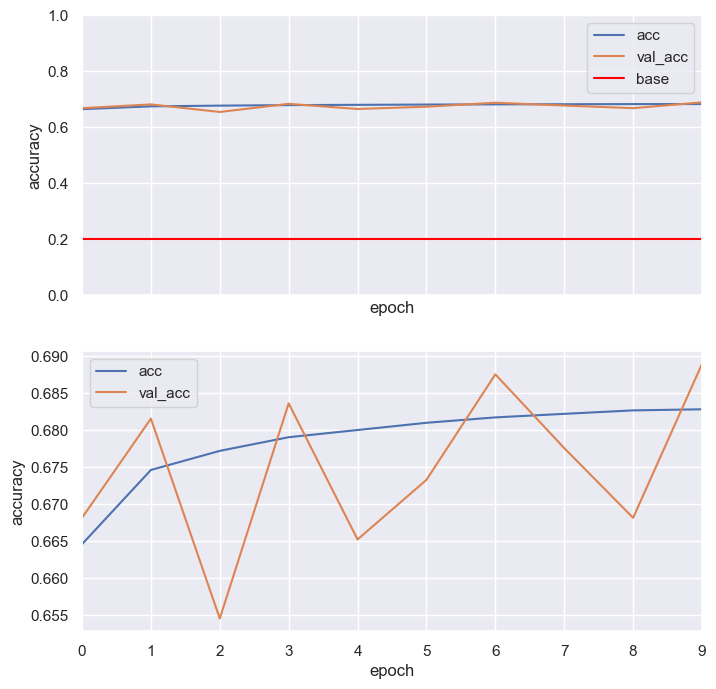

In [72]:
hist = history.history
acc, val_acc = hist["accuracy"], hist["val_accuracy"]

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 8), dpi=100)

for i, ax in enumerate(axes):
    ax.plot(acc, label="acc")
    ax.plot(val_acc, label="val_acc")
    
    ax.set_xlim(0, epochs - 1)
    if i == 0:
        ax.set_ylim(0.0, 1.0)
        ax.axhline(0.2, color="red", label="base")
        
    ax.grid(visible=True, axis="both")
    ax.legend()
    ax.set_xlabel("epoch")
    ax.set_ylabel("accuracy")

plt.show()

##### Evaluate

In [73]:
# Get probabilities per class
y_pred = model.predict(X_test)

21845/21845 [==============================] - 29s 1ms/step


In [74]:
# Get star predictions and negative/positive predictions
y_pred_multi = tf.argmax(y_pred, axis=1)
y_pred_binary = y_pred_multi >= 3

In [75]:
print("multi-class accuracy: " + str((y_pred_multi == y_test).numpy().sum() / len(y_test)))
print("(compare to ~0.2)")

multi-class accuracy: 0.6889666794463168
(compare to ~0.2)


In [76]:
print("binary accuracy: " + str((y_pred_binary == (y_test >= 3)).numpy().sum() / len(y_test)))
print("(compare to ~0.5)")

binary accuracy: 0.9201877464135915
(compare to ~0.5)


In [86]:
avg_err = tf.reduce_sum(tf.math.abs(y_test - y_pred_multi)) / len(y_test)
avg_err = avg_err.numpy()
print(f"Average of {avg_err:.4f} stars off")

Average of 0.3718 stars off


##### Visualize Attention

In [77]:
# Get attention scores
_, attns = model(X_test[:100], return_att=True)

# Get attention for each sample
attns = tf.reduce_mean(attns, axis=2)[:, 0, :]
attns

<tf.Tensor: shape=(100, 200), dtype=float32, numpy=
array([[0.1309183 , 0.04596469, 0.01737457, ..., 0.        , 0.        ,
        0.        ],
       [0.08700211, 0.08559155, 0.05517517, ..., 0.        , 0.        ,
        0.        ],
       [0.07742571, 0.15116367, 0.00762057, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.06035372, 0.09453103, 0.03575312, ..., 0.        , 0.        ,
        0.        ],
       [0.07201033, 0.07558928, 0.02392173, ..., 0.        , 0.        ,
        0.        ],
       [0.04302853, 0.05850716, 0.02301823, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)>

In [78]:
attns[0][:34]

<tf.Tensor: shape=(34,), dtype=float32, numpy=
array([0.1309183 , 0.04596469, 0.01737457, 0.044142  , 0.01941974,
       0.01728892, 0.03590509, 0.01574289, 0.02153557, 0.0292344 ,
       0.01269314, 0.01076315, 0.01304836, 0.01345175, 0.01490308,
       0.02777831, 0.00903813, 0.02144868, 0.01251277, 0.02433895,
       0.02161134, 0.01125041, 0.04065489, 0.0141254 , 0.01662029,
       0.06178557, 0.02393574, 0.02152768, 0.03651122, 0.0219862 ,
       0.01145301, 0.01646989, 0.01474874, 0.01030171], dtype=float32)>

<Original Text>
Let's face it, dim sum in Philly is just EH ok, so I just look for the cleanliness of the restaurant which is close to impossible too most of the time. Ocean City was never dirty, at least I haven't seen a cockroach crawling around. Now it's EVEN CLEANER!!!!

They've renovated and gotten a new dim sum chef. The place is clean, open, and the dim sum is tasty. OF course some dishes still have msg, but it's as bad as other places in Chinatown.
The shrimp dumplings here are cleaner too, they actually de-vein their shrimps.

<Preprocessed>
['let', "'", 's', 'face', 'dim', 'sum', 'philly', 'eh', 'ok', 'look', 'cleanliness', 'restaurant', 'close', 'impossible', 'time', 'ocean', 'city', 'dirty', 'haven', "'", 't', 'seen', 'cockroach', 'crawling', "'", 's', 'cleaner', "'", 've', 'renovated', 'gotten', 'new', 'dim', 'sum', 'chef', 'place', 'clean', 'open', 'dim', 'sum', 'tasty', 'course', 'dishes', 'msg', "'", 's', 'bad', 'places', 'chinatown', 'shrimp', 'dumplings', 'cleaner', '

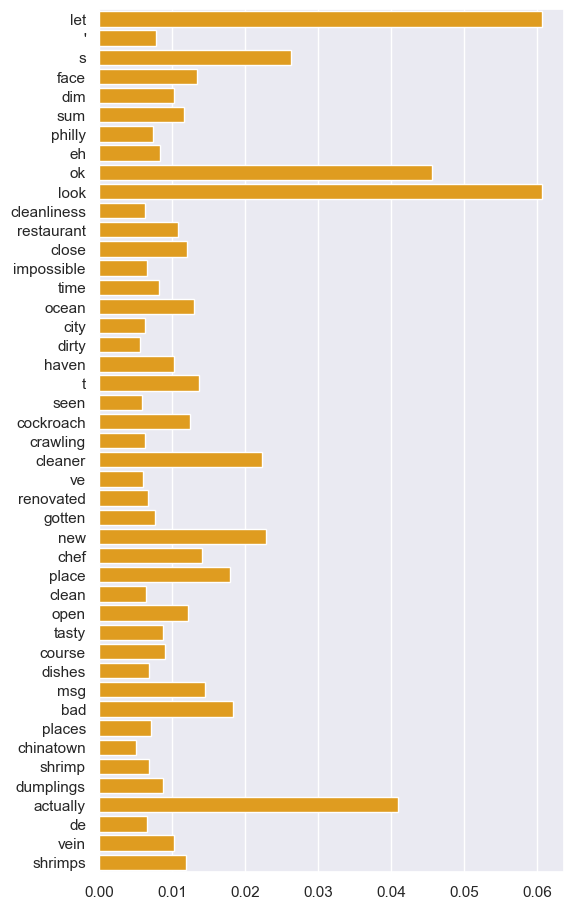

In [79]:
sample_idx = 10

# Get word sequences without oov words
in_seq = X_test_norm[sample_idx]
in_seq = [tok for tok in prep.tokenizer.sequences_to_texts(prep.tokenizer.texts_to_sequences(in_seq)) if tok]
seq_len = len(in_seq)

# Get attention values
attn_vals = attns[sample_idx][:seq_len].numpy()

print("<Original Text>")
print(test["text"].iloc[sample_idx])

print("\n<Preprocessed>")
print(in_seq)

plt.figure(figsize=(6, 0.2 * seq_len), dpi=100)
sns.barplot(y=in_seq, x=attn_vals, ci=None, color="orange")

plt.show()